In [2]:
'''
notes:
we have csvs with metadata pointing to each image of note
columns that matter:
- image
- all labels/majority labels/correct labels (segmentation coords, do correct if avail, then majority, then all)
- difficulty, agreement, total (qualified) reads (determine quality of annotations)


for intraventricular only (many ROIs, keep this in mind):
- image
- all annotations/region of interest (roi first, then all
- difficulty



plan (data preprocessing):
- get mini dataset to play with
    - around 1000 total to export to colab
    - want cols for np matrices, all labels, majority labels,
    correct labels, difficulty, agreement, total reads, and class

1. convert polygon coords/labels into binary masks
2. define 80%train, 10%validate, 10% test split
3. define functions for:
    - resizing images all to same size (if needed)
        - all data (512, 512, 3) i believe
    - normalizing pixels [0, 1] or [-1, 1]
    - removing flagged images
    - visualizing masks

from there, we can look into models and train
i have:
- linear
- logistic
- quadratic ^^
- lda, qda


Q: can i justify using a mini dataset if this is just classification ? ie this isnt main focus of project,
just exploration
'''

'\nnotes:\nwe have csvs with metadata pointing to each image of note\ncolumns that matter:\n- image\n- all labels/majority labels/correct labels (segmentation coords, do correct if avail, then majority, then all)\n- difficulty, agreement, total (qualified) reads (determine quality of annotations)\n\n\nfor intraventricular only (many ROIs, keep this in mind):\n- image\n- all annotations/region of interest (roi first, then all\n- difficulty\n\n\n\nplan (data preprocessing):\n- get mini dataset to play with\n    - around 1000 total to export to colab\n    - want cols for np matrices, all labels, majority labels,\n    correct labels, difficulty, agreement, total reads, and class\n\n1. convert polygon coords/labels into binary masks\n2. define 80%train, 10%validate, 10% test split\n3. define functions for:\n    - resizing images all to same size (if needed)\n        - all data (512, 512, 3) i believe\n    - normalizing pixels [0, 1] or [-1, 1]\n    - removing flagged images\n    - visualizi

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import glob
import os
import random
import cv2 as cv
import ast  # To safely parse strings containing lists/dictionaries
import json

In [4]:
from google.colab import drive
drive.mount('/content/drive')

file_dir = '/content/drive/MyDrive/Colab Notebooks'

def get_data(npz_file):
  data_npz = np.load(npz_file, allow_pickle=True)
  data_list = data_npz["data"].tolist()
  return data_list

epidural = get_data(file_dir + "/epidural.npz")
intraventricular = get_data(file_dir + "/intraventricular.npz")
multi = get_data(file_dir + "/multi.npz")
subdural = get_data(file_dir + "/subdural.npz")
subarachnoid = get_data(file_dir + "/subarachnoid.npz")
intraparenchymal = get_data(file_dir + "/intraparenchymal.npz")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
ep_ex = epidural[0]

print(ep_ex.keys())

dict_keys(['Origin', 'Image Matrix', 'All Labels', 'Majority Label', 'Correct Label', 'Difficulty', 'Agreement', 'Total Qualified Reads', 'Class'])


In [6]:
def display_image(img_matrix, img_name):
    plt.figure(figsize=(6, 6))
    if len(img_matrix.shape) == 2:
        plt.imshow(img_matrix, cmap="gray")  # Grayscale
    else:
        plt.imshow(img_matrix)
    plt.axis("off")
    plt.title(f"Image: {img_name}")
    plt.show()

    # Print shape of matrix (H, W, C)
    print(f"Image shape: {img_matrix.shape}")

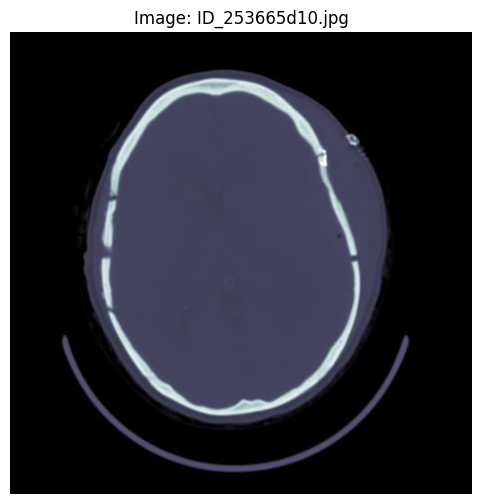

Image shape: (512, 512, 3)
[[{'x': 0.62809026, 'y': 0.24295628}, {'x': 0.6440478, 'y': 0.30550998}, {'x': 0.6223455, 'y': 0.36359555}, {'x': 0.640218, 'y': 0.41848963}, {'x': 0.70532495, 'y': 0.4695539}, {'x': 0.74298483, 'y': 0.5340225}, {'x': 0.6995802, 'y': 0.38657448}, {'x': 0.6606437, 'y': 0.2901907}], [{'x': 0.6514995, 'y': 0.28909296}, {'x': 0.62680125, 'y': 0.38187823}, {'x': 0.6595097, 'y': 0.42927215}, {'x': 0.69088316, 'y': 0.4479627}, {'x': 0.72759676, 'y': 0.5047019}, {'x': 0.71891904, 'y': 0.4346123}]]


In [7]:
#need to convert from string due to csv conversion
image_matrix = epidural[0]['Image Matrix']  # Convert string to array
display_image(image_matrix, epidural[0]['Origin'])

#print(np.max(image_matrix), np.min(image_matrix))

print((epidural[0]['All Labels']))

In [8]:
def create_binary_mask(image_shape, processed_labels):
    """
    Create a binary mask over an image using a given list of polygon points.

    :param image_shape: Tuple (height, width) of the image.
    :param processed_labels: List of polygons, each polygon being a list of dictionaries with 'x' and 'y' coordinates.
    :return: Binary mask as a NumPy array.
    """
    height, width, channels = image_shape

    # Create an empty mask
    mask = np.zeros((height, width), dtype=np.uint8)

    # Loop through each polygon in the processed_labels
    for poly in processed_labels:
        # Convert normalized points to pixel coordinates
        polygon_points = [
            [int(point["x"] * width), int(point["y"] * height)] for point in poly
        ]

        # Fill the polygon region with 1 (or 255 for visualization)
        if len(polygon_points) > 0:
            cv.fillPoly(mask, [np.array(polygon_points, dtype=np.int32)], 1)

    return mask

def overlay_mask(image, mask, alpha=0.5):
    """
    Overlay a binary mask onto an image.

    :param image: The input image (in BGR format).
    :param mask: Binary mask to overlay (should be the same size as the image).
    :param alpha: Transparency factor for the mask overlay (default is 0.5).
    :return: The image with the mask overlaid.
    """

    # Ensure image is in uint8 format
    if image.dtype != np.uint8:
        # If image values are in the range [0, 1], scale them up to 255
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        else:
            image = image.astype(np.uint8)

    # Create a colored mask with the same shape as the image
    mask_colored = np.zeros_like(image)
    # Multiply mask by 255 to get values in the range [0, 255] and assign to green channel
    mask_colored[:, :, 1] = (mask * 255).astype(np.uint8)
    # Ensure mask_colored is in uint8 format
    mask_colored = mask_colored.astype(np.uint8)

    # Now blend the image and the mask using addWeighted
    overlay = cv.addWeighted(image, 1, mask_colored, alpha, 0)

    return overlay


In [9]:
labels = epidural[0]["All Labels"]
print(len(labels), len(labels[0]), len(labels[0][0]))

for label in labels:
  for coord in label:
    print(f"x: {coord['x']}, y: {coord['y']}")

2 8 2
x: 0.62809026, y: 0.24295628
x: 0.6440478, y: 0.30550998
x: 0.6223455, y: 0.36359555
x: 0.640218, y: 0.41848963
x: 0.70532495, y: 0.4695539
x: 0.74298483, y: 0.5340225
x: 0.6995802, y: 0.38657448
x: 0.6606437, y: 0.2901907
x: 0.6514995, y: 0.28909296
x: 0.62680125, y: 0.38187823
x: 0.6595097, y: 0.42927215
x: 0.69088316, y: 0.4479627
x: 0.72759676, y: 0.5047019
x: 0.71891904, y: 0.4346123


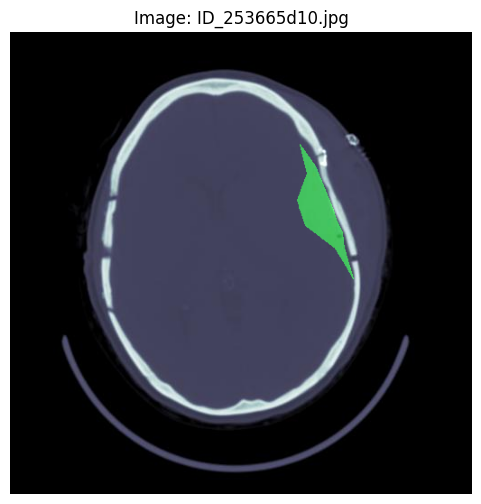

Image shape: (512, 512, 3)


In [10]:
overlayed = overlay_mask(image_matrix, create_binary_mask(image_matrix.shape, labels))
display_image(overlayed, epidural[0]['Origin'])

In [11]:
'''
flow for regression:

flatten images for X, label for y (ie epidural, etc)
train models w/traintestsplit
test on test set

ideas: use pca for more accuracy ?
'''

'\nflow for regression:\n\nflatten images for X, label for y (ie epidural, etc)\ntrain models w/traintestsplit\ntest on test set\n\nideas: use pca for more accuracy ?\n'

In [12]:
def getLabel(label):
  if label == "epidural":
    return 0
  elif label == "intraparenchymal":
    return 1
  elif label == "intraventricular":
    return 2
  elif label == "subarachnoid":
    return 3
  elif label == "subdural":
    return 4
  elif label == "multi":
    return 5

In [13]:
def appendData(npzList, X, y):
  for data in npzList:
    image = data["Image Matrix"]
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    flattened = gray_image.reshape(1, -1)
    #print(flattened.shape)
    X.append(flattened)

    label = data["Class"]
    y.append(getLabel(label))

  return X, y

X = []
y = []

X, y = appendData(epidural, X, y)
X, y = appendData(intraparenchymal, X, y)
X, y = appendData(intraventricular, X, y)
X, y = appendData(subarachnoid, X, y)
X, y = appendData(subdural, X, y)
X, y = appendData(multi, X, y)

X = np.vstack(X)
y = np.array(y).reshape(-1, 1)


print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (600, 262144)
y shape: (600, 1)


ISSUE: regression models trained to predict single values, not masks, so this won't work

want to try:
- linear regression X
- logistic regression X
- lda X
- QDA X
- random forest X
- naive bayes X
- quadratic linear, logistic, pca (to reduce dimensionality)
- knn (w/pca)
- svm (w/pca)

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(480, 262144) (480, 6) (120, 262144) (120, 6)


In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

Training LinearRegression: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


In [26]:
y_pred_encoded = model.predict(X_test)

print(y_pred_encoded.shape, y_test.shape)

# For each sample, select the class with the highest predicted value
y_pred = np.argmax(y_pred_encoded, axis=1)
y_true = np.argmax(y_test, axis=1)

print(y_pred.shape, y_true.shape)

#calculate accuracy
np.mean(y_true == y_pred) #23% accuracy :/ pretty bad! but expected

(120, 6) (120, 6)
(120,) (120,)


np.float64(0.23333333333333334)

In [30]:
#LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train_log, y_train_log)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [33]:
# Using score() method (returns accuracy)
accuracy = model.score(X_test_log, y_test_log)
print(accuracy)

# Or using predict() with metrics
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test_log)
report = classification_report(y_test_log, y_pred)

print(accuracy, report) #Accuracy of 21.6%, just as bad a linear regression right now

0.21666666666666667
0.21666666666666667               precision    recall  f1-score   support

           0       0.21      0.17      0.19        23
           1       0.39      0.35      0.37        20
           2       0.24      0.21      0.22        19
           3       0.19      0.18      0.18        17
           4       0.13      0.24      0.17        17
           5       0.21      0.17      0.19        24

    accuracy                           0.22       120
   macro avg       0.23      0.22      0.22       120
weighted avg       0.23      0.22      0.22       120



In [14]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis()

In [15]:
y_pred = lda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"LDA Accuracy: {accuracy:.4f}") #20.8%

LDA Accuracy: 0.2083


In [17]:
#QDA:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(

QuadraticDiscriminantAnalysis()

In [18]:
y_pred = qda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"QDA Accuracy: {accuracy:.4f}") #also 20.83% accuracy?

QDA Accuracy: 0.2083


Discussion: why do we think our models suck?
1. Im training on 100 images per category, not nearly enough for a good model
2. Perhaps our relationships aren't linear, and quadratic would provide better accuracy!

In [34]:
#Random Forest
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(
    n_estimators=100, #number of trees in forest
    n_jobs=-1,  # Use all cores
    verbose=1
)

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.5s finished


RandomForestClassifier(n_jobs=-1, verbose=1)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy: 0.3083

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.18      0.15      0.16        20
     Class 1       0.44      0.40      0.42        20
     Class 2       0.39      0.45      0.42        20
     Class 3       0.29      0.30      0.29        20
     Class 4       0.33      0.45      0.38        20
     Class 5       0.14      0.10      0.12        20

    accuracy                           0.31       120
   macro avg       0.30      0.31      0.30       120
weighted avg       0.30      0.31      0.30       120



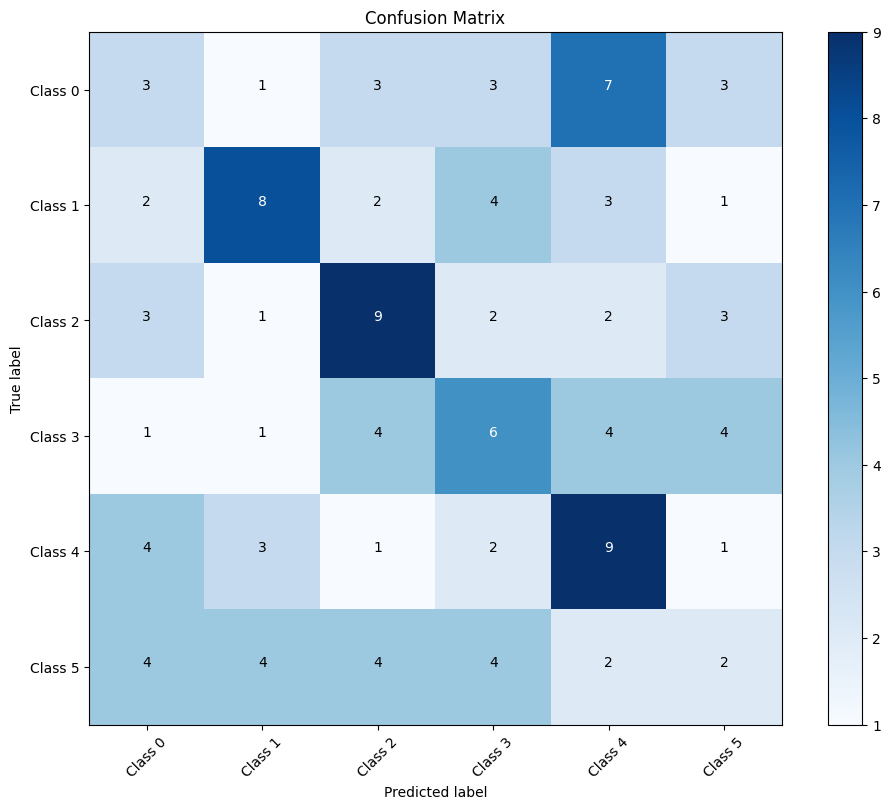

In [36]:
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}") #30%, goin up!!!!

# Print classification report
print("\nClassification Report:")
class_names = [f"Class {i}" for i in np.unique(y)]  # Replace with actual class names if available
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [16]:
#NAIVE BAYES

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# For MultinomialNB, features need to be non-negative
# Scale features to [0,1] range if using MultinomialNB
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gnb_model = GaussianNB()
gnb_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

Gaussian NB Accuracy: 0.1917

Gaussian NB Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        20
     Class 1       0.00      0.00      0.00        20
     Class 2       0.37      0.35      0.36        20
     Class 3       0.14      0.25      0.18        20
     Class 4       0.29      0.25      0.27        20
     Class 5       0.19      0.30      0.23        20

    accuracy                           0.19       120
   macro avg       0.17      0.19      0.17       120
weighted avg       0.17      0.19      0.17       120



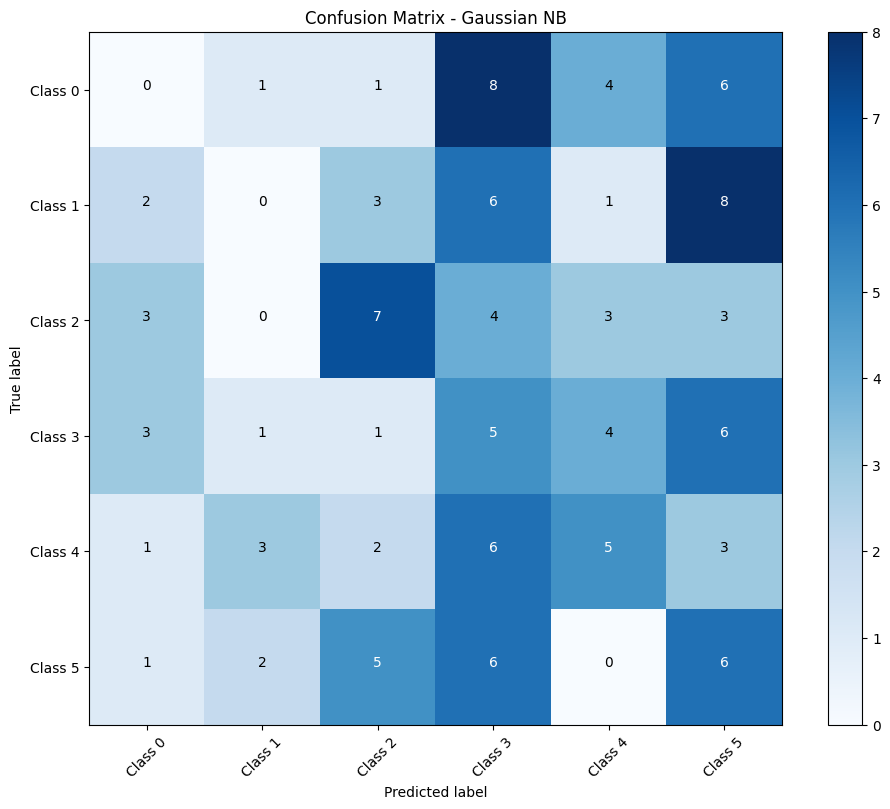

In [17]:
y_pred_gnb = gnb_model.predict(X_test_scaled)

accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f"Gaussian NB Accuracy: {accuracy_gnb:.4f}") #.1917 accuracy lol


#report
print("\nGaussian NB Classification Report:")
class_names = [f"Class {i}" for i in np.unique(y)]  # Replace with actual class names if available
print(classification_report(y_test, y_pred_gnb, target_names=class_names))


plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_gnb)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - Gaussian NB')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#====================================================================PCA METHODS=====================================================

In [ ]:
#KNN

from sklearn.neighbors import KNeighborsClassifier

#APPLY PCA HERE


def find_optimal_k(X_train, y_train, X_test, y_test, max_k=15):
    k_values = range(1, max_k + 1)
    accuracies = []

    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print(f"k={k}, Accuracy: {accuracy:.4f}")

    # Plot accuracies for different k values
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, marker='o')
    plt.title('Accuracy vs k Value')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(k_values)
    plt.show()

    # Find best k
    best_k = k_values[np.argmax(accuracies)]
    print(f"Best k: {best_k} with accuracy: {max(accuracies):.4f}")

    return best_k


# best_k = find_optimal_k(X_train_scaled, y_train, X_test_scaled, y_test)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = KNeighborsClassifier(
    n_neighbors=5,       # Number of neighbors to consider
    weights='uniform',   # Weight function used ('uniform' or 'distance')
    algorithm='auto',    # Algorithm to compute nearest neighbors
    n_jobs=-1            # Use all available cores
)

model.fit(X_train_scaled, y_train)

In [ ]:
# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
class_names = [f"Class {i}" for i in np.unique(y)]  # Replace with actual class names if available
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#SVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Scale features - important for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM model
model = SVC(
    kernel='rbf',        # Radial basis function kernel
    C=1.0,               # Regularization parameter
    gamma='scale',       # Kernel coefficient
    decision_function_shape='ovr',  # One-vs-rest approach for multiclass
    probability=True,    # Enable probability estimates
    verbose=True
)

model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibSVM]

In [ ]:
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
class_names = [f"Class {i}" for i in np.unique(y)]  # Replace with actual class names if available
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()